## Цель ноутбука: изучение метода Few Shots Learning

Проблемы со знаками решены так:

| Знак | Описание | Источник |
| ------------- | ------------- | ---- |
| 1.6 | Пересечение равнозначных дорог | Надеемся на удачу |
| 1.31 | Туннель | Надеемся на удачу |
| 2.4 | Уступите дорогу | GTSRB Recognition |
| 3.21 | Конец запрещения обгона | GTSRB Recognition |
| 3.22 | Обгон грузовым автомобилям запрещен | GTSRB Recognition |
| 3.23 | Конец запрещения обгона грузовым автомобилям | GTSRB Recognition |
| 3.24-90 | Огр 90 | Объеденили |
| 3.24-100 | Огр 100 | Объеденили |
| 3.24-110 | Огр 110 | Объеденили |
| 3.24-120 | Огр 120 | Объеденили |
| 3.24-130 | Огр 130 | Объеденили |
| 3.25 | Конец огр. максимальной скорости | GTSRB Recognition |
| 3.31 | Конец всех ограничений | GTSRB Recognition |
| 6.3.2 | Зона для разворота | Надеемся на удачу |

Инициализация библиотек

In [1]:
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from torch import nn
import seaborn as sns
import pandas as pd
import os
import pathlib
import shutil
import cv2
import PIL
import cv2
import sys
from datetime import datetime

TEXT_COLOR = 'black'
# Зафиксируем состояние случайных чисел
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
%matplotlib inline
plt.rcParams["figure.figsize"] = (17,10)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Инициализация основных путей и папки src

In [2]:
PROJECT_ROOT = pathlib.Path('..').resolve()
    
DATA_DIR = PROJECT_ROOT / 'data'
SRC_PATH = str(PROJECT_ROOT / 'src')

if SRC_PATH not in sys.path:
    sys.path.append(SRC_PATH)

In [16]:
PROJECT_ROOT

PosixPath('/home/notadmin/adas/adas_system/notebooks/SignDetectorAndClassifier')

In [4]:
DATASET_PREFIX = DATA_DIR / 'ENCODER_DATASET'
RTDS_DF = pd.read_csv(DATASET_PREFIX / 'WIDE_DATASET_4_ENCODER.csv')

RTDS_DF['filepath'] = RTDS_DF['filepath'].apply(lambda x: str(DATASET_PREFIX / x))

# UNFIX TRAIN
# SIMPLE_FIX = True
# JUST_FIX = False
# RTDS_DF.drop_duplicates(subset=['filepath'], inplace=True)
# RTDS_DF = RTDS_DF.groupby(['sign', 'set']).apply(lambda x: x.sample(frac=0.01))
# RTDS_DF.drop_duplicates(subset=['SET', 'SIGN'], inplace=True)

RTDS_DF

,filepath,sign,set,encoded
0,/home/notadmin/adas/adas_system/notebooks/Sign...,1.23,train,18
1,/home/notadmin/adas/adas_system/notebooks/Sign...,1.23,train,18
2,/home/notadmin/adas/adas_system/notebooks/Sign...,1.23,train,18
3,/home/notadmin/adas/adas_system/notebooks/Sign...,1.23,train,18
4,/home/notadmin/adas/adas_system/notebooks/Sign...,1.17,valid,9
...,...,...,...,...
386947,/home/notadmin/adas/adas_system/notebooks/Sign...,7.7,train,100
386948,/home/notadmin/adas/adas_system/notebooks/Sign...,7.7,train,100
386949,/home/notadmin/adas/adas_system/notebooks/Sign...,7.7,train,100
386950,/home/notadmin/adas/adas_system/notebooks/Sign...,7.7,train,100


In [5]:
len(set(RTDS_DF['sign']))
from utils.fs import imread_rgb

In [6]:
class SignDataset(torch.utils.data.Dataset):
    def __init__(self, df, set_label=None, hyp=None, transform=None, le=None):
                
        self.transform = transform
        
        if set_label == None:
            self.df = df
        else:
            self.df = df[df['set']==set_label]
        
    def __len__(self):
        return len(self.df.index)
    
    def __getitem__(self, index): 
        label = int(self.df.iloc[index]['encoded'])
        path = str(self.df.iloc[index]['filepath'])
        sign = str(self.df.iloc[index]['sign'])
        img = imread_rgb(path)
                
        # augment 
        if self.transform:
            img = self.transform(image=img)['image']
        # /augment
        
        img = img / 255
        return img, label, (path, sign)

In [7]:
from albumentations.augmentations.geometric.transforms import Perspective, ShiftScaleRotate
from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations.transforms import PadIfNeeded
from albumentations.augmentations.geometric.resize import LongestMaxSize

img_size = 40


minimal_transform = A.Compose(
        [
        LongestMaxSize(img_size),
        PadIfNeeded(
            img_size, 
            img_size, 
            border_mode=cv2.BORDER_CONSTANT, 
            value=0
        ),
        ToTensorV2(),
        ]
    )

transform = A.Compose(
        [
        A.Blur(blur_limit=2),
        A.CLAHE(p=0.5),
        A.Perspective(scale=(0.01, 0.1), p=0.5), 
        A.ShiftScaleRotate(shift_limit=0.05,
                           scale_limit=0.05,
                           interpolation=cv2.INTER_LANCZOS4, 
                           border_mode=cv2.BORDER_CONSTANT, 
                           value=(0,0,0),
                           rotate_limit=6, p=0.5),
        A.RandomGamma(
            gamma_limit=(50, 130), 
            p=1
        ),
        A.ImageCompression(quality_lower=80, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.5, 
                                   contrast_limit=0.3, 
                                   brightness_by_max=False, 
                                   p=0.5),
        A.CoarseDropout(max_height=3, 
                        max_width=3, 
                        min_holes=1, 
                        max_holes=3, 
                        p=0.5),
        LongestMaxSize(img_size),
        PadIfNeeded(
            img_size, 
            img_size, 
            border_mode=cv2.BORDER_CONSTANT, 
            value=0
        ),
        ToTensorV2(),
        ]
    )

train_dataset = SignDataset(RTDS_DF, 
                            set_label='train',  
                            transform=transform, 
                            hyp=None)

valid_dataset = SignDataset(RTDS_DF, 
                            set_label='valid',  
                            transform=minimal_transform, 
                            hyp=None)

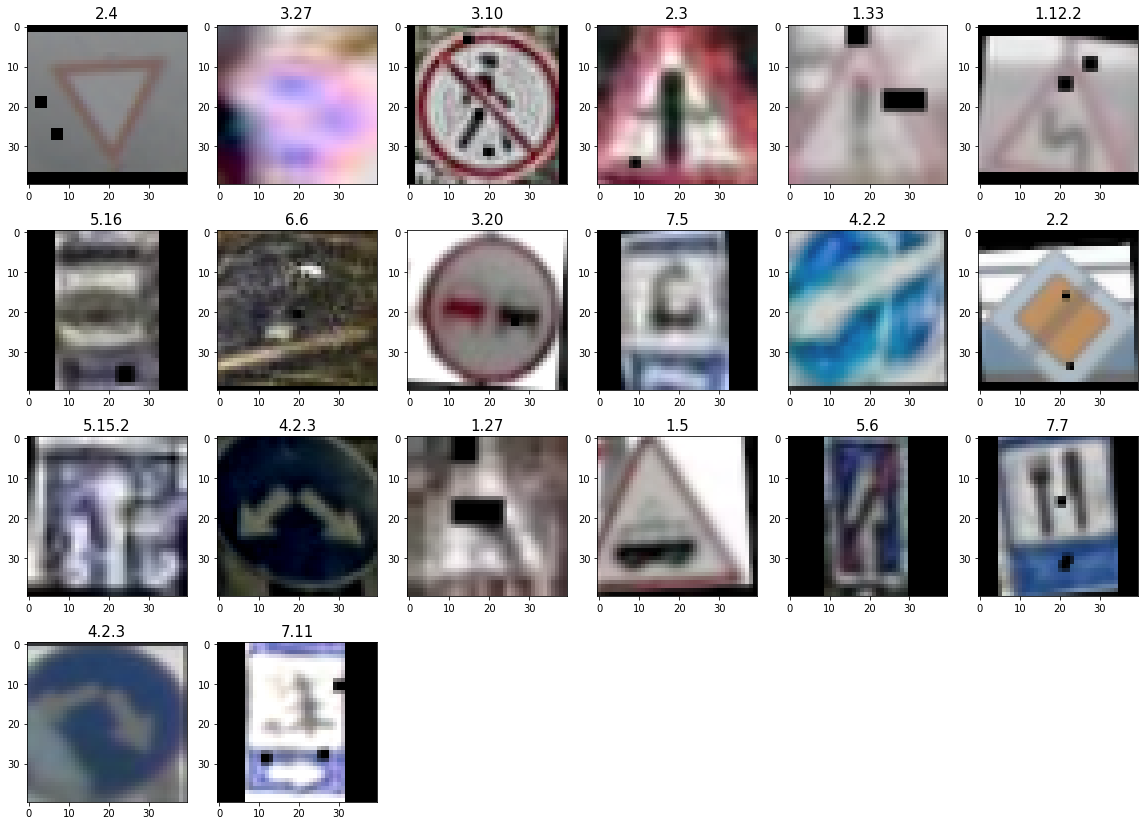

In [8]:
def getNSamplesFromDataSet(ds, N):
    random_index = random.sample(range(0, len(ds)), N)
    ret = []
    for index in random_index:
        ret.append(ds[index])
    return ret

IMG_COUNT = 18
nrows, ncols = 70, 6
fig = plt.figure(figsize = (16,200))

PLOT_SOFT_LIMIT = 20

TEMP_DS = getNSamplesFromDataSet(train_dataset, 20)
# TEMP_DS = train_dataset.sort_values(['SIGN'], axis=1)
# TEMP_DS = train_dataset
for idx, (img, encoded_label, info) in enumerate(TEMP_DS):
    
    img = torch.Tensor.permute(img, [1, 2, 0]).numpy() 
    ax = fig.add_subplot(nrows, ncols, idx+1)
        
    ax.imshow(img, aspect=1)
    
    title = str(info[1])
    
    ax.set_title(title, fontsize=15)
    
    if idx > PLOT_SOFT_LIMIT:
        print('[!] plot soft limit reached. Breaking.')
        break
        
plt.tight_layout()
plt.show()

In [9]:
batch_size = 1080 # HANDLE PARAM
num_workers = 8 # HANDLE PARAM

from torch.utils.data import DataLoader

def getDataLoaderFromDataset(dataset, shuffle=False, drop_last=True):
    
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=shuffle,
        drop_last=drop_last
    )
    
    return loader


train_loader = getDataLoaderFromDataset(
    train_dataset,
    shuffle=True
)

In [10]:
def saveCheckpoint(model, scheduler, optimizer, epoch, filename):
    torch.save({
        'epoch': epoch if epoch else None,
        'model': model.state_dict() if model else None,
        'optimizer': optimizer.state_dict() if optimizer else None,
        'scheduler': scheduler.state_dict() if scheduler else None
    }, filename)

def loadCheckpoint(model, scheduler, optimizer, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    epoch = checkpoint['epoch']
    return model, optimizer, scheduler, epoch

In [11]:
from torchvision.models import resnet

def create_encoder(emb_dim, bias=True):
    model = resnet.resnet18(pretrained=True)
    model.fc = nn.Linear(in_features=512, out_features=emb_dim, bias=bias)

    return model

encoder = create_encoder(512, True)
# encoder

In [12]:
@torch.no_grad()
def simpleGetAllEmbeddings(model, dataset, batch_size, dsc=''):
    
    dataloader = getDataLoaderFromDataset(
        dataset,
        shuffle=True,
        drop_last=False
    )
    
    s, e = 0, 0
    pbar = tqdm(
        enumerate(dataloader), 
        total=len(dataloader),
        position=0,
        leave=False,
        desc='Getting all embeddings...' + dsc)
    info_arr = []
    
    add_info_len = None
    
    for idx, (data, labels, info) in pbar:
        data = data.to(device)
        
        q = model(data)
        
        if labels.dim() == 1:
            labels = labels.unsqueeze(1)
        if idx == 0:
            labels_ret = torch.zeros(
                len(dataloader.dataset),
                labels.size(1),
                device=device,
                dtype=labels.dtype,
            )
            all_q = torch.zeros(
                len(dataloader.dataset),
                q.size(1),
                device=device,
                dtype=q.dtype,
            )
        
        info = np.array(info)
        if add_info_len == None:
            add_info_len = info.shape[0]
        
        info_arr.extend(info.T.reshape((-1, add_info_len)))
        e = s + q.size(0)
        all_q[s:e] = q
        labels_ret[s:e] = labels
        s = e  
    
    all_q = torch.nn.functional.normalize(all_q)
    return all_q, labels_ret, info_arr
    
### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###    
@torch.no_grad()
def test(train_set, test_set, model, accuracy_calculator, batch_size):
    model.eval()
    train_embeddings, train_labels, _ = simpleGetAllEmbeddings(model, train_set, batch_size, ' for train')
    test_embeddings, test_labels, _ = simpleGetAllEmbeddings(model, test_set, batch_size, ' for test')
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, train_embeddings, test_labels, train_labels, False
    )
    print(accuracies)
    # print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))
    return accuracies["precision_at_1"]
    

### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    loss_sum = 0
    
    pbar = tqdm(
        enumerate(train_loader), 
        total=len(train_loader),
        position=0,
        leave=False,
        desc='WAITING...')
    
    USING_CentroidTripletLoss_FLAG = False
    USING_MultiSimilarityMiner_FLAG = False
    if isinstance(loss_func, losses.CentroidTripletLoss):
        USING_CentroidTripletLoss_FLAG = True
    if isinstance(mining_func, miners.MultiSimilarityMiner):
        USING_MultiSimilarityMiner_FLAG = True
        
    for batch_idx, (data, labels, _) in pbar:
        
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)

        if USING_CentroidTripletLoss_FLAG:
            embeddings = torch.tensor(
                [c_f.angle_to_coord(a) for a in embeddings],
                requires_grad=True,
                dtype=dtype,
            ).to(
                device
            )
            print(embeddings.shape)
            print(labels.shape)
            loss = loss_func(embeddings, labels)
        else:
            indices_tuple = mining_func(embeddings, labels)
            loss = loss_func(embeddings, labels, indices_tuple)

        instant_loss = loss.item()
        loss_sum += instant_loss
        
        loss.backward()
        optimizer.step()
        
        try:
            pbar.set_description("TRAIN: INSTANT MEAN LOSS %f, MINED TRIPLET: %d" % 
                             (round(instant_loss / len(labels), 3),
                             mining_func.num_triplets)
                            )
        except:
            pbar.set_description("TRAIN: INSTANT MEAN LOSS %f" % 
                             (round(instant_loss / len(labels), 3))
                            ) 
            
            
    return loss_sum / (train_loader.batch_size * len(train_loader))

In [13]:
%reload_ext tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/classifier')
%tensorboard --logdir runs --host=127.0.0.1
print('tensorboard initiated')

tensorboard initiated


In [ ]:
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

from pytorch_metric_learning.utils import common_functions as c_f
from tqdm.notebook import trange, tqdm

config = {
    'lr': 0.1,
    'epochs': 500,
    'momentum':  0.937,
    'margin': 0.6
}

optimizer = torch.optim.SGD(encoder.parameters(), lr=config['lr'], momentum=config['momentum'], nesterov=True)

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                              base_lr=0.00001, 
                                              max_lr=config['lr'],
                                              step_size_up=50,
                                              step_size_down=20,
                                              mode="exp_range",
                                              gamma=0.1,
                                              cycle_momentum=False
                                            )
distance = distances.LpDistance()
reducer = reducers.AvgNonZeroReducer()
loss_func = losses.TripletMarginLoss(
    margin=config['margin'], 
    distance=distance, 
    reducer=reducer
)

mining_func = miners.TripletMarginMiner(margin=config['margin'], distance=distance, type_of_triplets="hard")

accuracy_calculator = AccuracyCalculator(device=torch.device('cuda'), k=1)

try:
    # encoder, optimizer, scheduler, started_epoch = loadCheckpoint(encoder, scheduler, optimizer, 'sample')
    started_epoch
    print('[+] check point loaded')
except:
    started_epoch = 0
    print('[!] check point doesnt exist')

encoder.to(device)    
    
torch.cuda.empty_cache()

pbar = trange(
        started_epoch, 
        config['epochs'], 
        initial=started_epoch, 
        total=config['epochs'],
        leave=True,
        desc='WAITING FOR FIRST EPOCH END...')

mean_acc = -1
# assert False
for epoch in pbar:
    
    train_loss = train(encoder, loss_func, mining_func, device, train_loader, optimizer, epoch)
    
    mean_acc = test(train_dataset, valid_dataset, encoder, accuracy_calculator, batch_size)
    
    if (epoch % 2 == 0):
        saveCheckpoint(encoder, scheduler, optimizer, epoch, 
                       'encoder_loss_' + str(round(train_loss, 5)) + '_acc_' + str(round(mean_acc, 3)))

    lr_val = scheduler.get_last_lr()[0]
    scheduler.step()
    
    writer.add_scalar('mean valid accuracy', mean_acc, epoch)
    writer.add_scalar('traineng loss', train_loss, epoch)
    writer.add_scalar('learning rate', lr_val, epoch)
        
    pbar.set_description("PER %d EPOCH: TRAIN LOSS: %.1e; VALID ACCUR: %.4f, LR %.1e" % (
        epoch,
        train_loss, 
        mean_acc,
        lr_val)
    )

2022-04-27 01:38:15,765 [INFO] Loading faiss with AVX2 support.
2022-04-27 01:38:15,765 [INFO] Could not load library with AVX2 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")
2022-04-27 01:38:15,766 [INFO] Loading faiss.
2022-04-27 01:38:15,776 [INFO] Successfully loaded faiss.


[!] check point doesnt exist


WAITING FOR FIRST EPOCH END...:   0%|          | 0/500 [00:00<?, ?it/s]

WAITING...:   0%|          | 0/292 [00:00<?, ?it/s]

Getting all embeddings... for train:   0%|          | 0/293 [00:00<?, ?it/s]

Getting all embeddings... for test:   0%|          | 0/19 [00:00<?, ?it/s]

2022-04-27 01:40:13,771 [WARNING] 
If you're looking for MAP@1 instead of MAP@R, then you should use 'mean_average_precision' rather than mean_average_precision_at_r
2022-04-27 01:40:13,771 [INFO] running k-nn with k=1
2022-04-27 01:40:13,772 [INFO] embedding dimensionality is 512
2022-04-27 01:40:14,892 [INFO] running k-means clustering with k=101
2022-04-27 01:40:14,892 [INFO] embedding dimensionality is 512


{'AMI': 0.42372219481361617, 'NMI': 0.45526744362486987, 'mean_average_precision': 0.5923167385339083, 'mean_average_precision_at_r': 0.5923167385339083, 'mean_reciprocal_rank': 0.592316746711731, 'precision_at_1': 0.5923167385339083, 'r_precision': 0.5923167385339083}


WAITING...:   0%|          | 0/292 [00:00<?, ?it/s]

Getting all embeddings... for train:   0%|          | 0/293 [00:00<?, ?it/s]

Getting all embeddings... for test:   0%|          | 0/19 [00:00<?, ?it/s]

2022-04-27 01:42:08,607 [WARNING] 
If you're looking for MAP@1 instead of MAP@R, then you should use 'mean_average_precision' rather than mean_average_precision_at_r
2022-04-27 01:42:08,607 [INFO] running k-nn with k=1
2022-04-27 01:42:08,608 [INFO] embedding dimensionality is 512
2022-04-27 01:42:09,531 [INFO] running k-means clustering with k=101
2022-04-27 01:42:09,532 [INFO] embedding dimensionality is 512


{'AMI': 0.5690270673274168, 'NMI': 0.5924910797522781, 'mean_average_precision': 0.7072716581732654, 'mean_average_precision_at_r': 0.7072716581732654, 'mean_reciprocal_rank': 0.7072716355323792, 'precision_at_1': 0.7072716581732654, 'r_precision': 0.7072716581732654}


WAITING...:   0%|          | 0/292 [00:00<?, ?it/s]

Getting all embeddings... for train:   0%|          | 0/293 [00:00<?, ?it/s]

Getting all embeddings... for test:   0%|          | 0/19 [00:00<?, ?it/s]

2022-04-27 01:44:00,615 [WARNING] 
If you're looking for MAP@1 instead of MAP@R, then you should use 'mean_average_precision' rather than mean_average_precision_at_r
2022-04-27 01:44:00,616 [INFO] running k-nn with k=1
2022-04-27 01:44:00,616 [INFO] embedding dimensionality is 512
2022-04-27 01:44:01,546 [INFO] running k-means clustering with k=101
2022-04-27 01:44:01,546 [INFO] embedding dimensionality is 512


{'AMI': 0.7184303998961081, 'NMI': 0.73375463711215, 'mean_average_precision': 0.8323206585652685, 'mean_average_precision_at_r': 0.8323206585652685, 'mean_reciprocal_rank': 0.8323206305503845, 'precision_at_1': 0.8323206585652685, 'r_precision': 0.8323206585652685}


WAITING...:   0%|          | 0/292 [00:00<?, ?it/s]

Getting all embeddings... for train:   0%|          | 0/293 [00:00<?, ?it/s]

Getting all embeddings... for test:   0%|          | 0/19 [00:00<?, ?it/s]

2022-04-27 01:45:51,759 [WARNING] 
If you're looking for MAP@1 instead of MAP@R, then you should use 'mean_average_precision' rather than mean_average_precision_at_r
2022-04-27 01:45:51,760 [INFO] running k-nn with k=1
2022-04-27 01:45:51,760 [INFO] embedding dimensionality is 512
2022-04-27 01:45:52,747 [INFO] running k-means clustering with k=101
2022-04-27 01:45:52,747 [INFO] embedding dimensionality is 512


{'AMI': 0.7838009798542241, 'NMI': 0.795478240734056, 'mean_average_precision': 0.8991571932575461, 'mean_average_precision_at_r': 0.8991571932575461, 'mean_reciprocal_rank': 0.8991571664810181, 'precision_at_1': 0.8991571932575461, 'r_precision': 0.8991571932575461}


WAITING...:   0%|          | 0/292 [00:00<?, ?it/s]

Getting all embeddings... for train:   0%|          | 0/293 [00:00<?, ?it/s]

Getting all embeddings... for test:   0%|          | 0/19 [00:00<?, ?it/s]

2022-04-27 01:47:42,072 [WARNING] 
If you're looking for MAP@1 instead of MAP@R, then you should use 'mean_average_precision' rather than mean_average_precision_at_r
2022-04-27 01:47:42,073 [INFO] running k-nn with k=1
2022-04-27 01:47:42,073 [INFO] embedding dimensionality is 512
2022-04-27 01:47:42,993 [INFO] running k-means clustering with k=101
2022-04-27 01:47:42,993 [INFO] embedding dimensionality is 512


{'AMI': 0.8272434140063881, 'NMI': 0.8364604074071822, 'mean_average_precision': 0.9362994903959232, 'mean_average_precision_at_r': 0.9362994903959232, 'mean_reciprocal_rank': 0.9362995028495789, 'precision_at_1': 0.9362994903959232, 'r_precision': 0.9362994903959232}


WAITING...:   0%|          | 0/292 [00:00<?, ?it/s]

Getting all embeddings... for train:   0%|          | 0/293 [00:00<?, ?it/s]

In [ ]:
'encoder_loss_' + str(float(3.5, 5)) + '_acc_' + str(float(mean_acc, 3))

In [ ]:
saveCheckpoint(encoder, None, optimizer, epoch, 'last_encoder')
assert False, 'END'

In [ ]:
additional_DF = pd.DataFrame(columns=RTDS_DF.columns)

encode_offset = max(set(RTDS_DF['ENCODED_LABEL'])) + 1
files = os.listdir(DATA_DIR / 'additional_sign')

sign_list = list(set([x.split('_')[0] for x in files]))
for file in files:
    sign = file.split('_')[0]
    # print(file.split('_')[1].split('.')[0])
    encoded_label = encode_offset + int(sign_list.index(sign))
    
    # print(sign)
    row = {'filepath': str(DATA_DIR / 'additional_sign' / file), 'SIGN':sign, 'ENCODED_LABEL':encoded_label, 'SET':'valid'} 
    additional_DF = additional_DF.append(row, ignore_index=True)

display(additional_DF)    
additional_dataset = SignDataset(
    additional_DF,
    transform=minimal_transform
)

add_dataset_dict = dict(zip(additional_DF.ENCODED_LABEL, additional_DF.SIGN))

IMG_COUNT = 18
nrows, ncols = 70, 6
fig = plt.figure(figsize = (16,200))

PLOT_SOFT_LIMIT = 20

for idx, (img, encoded_label, info) in enumerate(additional_dataset):
    
    img = torch.Tensor.permute(img, [1, 2, 0]).numpy() 
    ax = fig.add_subplot(nrows, ncols, idx+1)
        
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), aspect=1)
    
    title = str(info[1])
    
    ax.set_title(title, fontsize=15)
    
    if idx > PLOT_SOFT_LIMIT:
        print('[!] plot soft limit reached. Breaking.')
        break
plt.tight_layout()

label_dict = dict(zip(RTDS_DF.ENCODED_LABEL, RTDS_DF.SIGN))
label_dict.update(add_dataset_dict)

In [ ]:
@torch.no_grad()
def getInfoForFig(
    model, 
    dataset, 
    batch_size, 
    additional_dataset,
    main_dataset_marker_size=10,
    additional_dataset_marker_size=20,
    dot_limit=1000):
    
    model.eval()
    
    if len(dataset) > dot_limit:
        print("[!] Dot limit! Random choice", dot_limit, '\nSrc len', len(dataset))
        indicies = np.random.choice(len(dataset), dot_limit, replace=False)
        dataset = torch.utils.data.Subset(dataset, indicies)
        
    embeddings, labels, info = simpleGetAllEmbeddings(model, dataset, batch_size, dsc='for main dataset')
    embeddings = embeddings.cpu().numpy()
    labels = labels.cpu().numpy().flatten()[:, None]
    size = np.ones(labels.shape) * main_dataset_marker_size
    
    if additional_dataset:
        embeddings_addon, labels_addon, info_addon = simpleGetAllEmbeddings(
            model, 
            additional_dataset, 
            batch_size, 
            dsc='for addon')
        
        embeddings_addon = embeddings_addon.cpu().numpy()
        labels_addon = labels_addon.cpu().numpy().flatten()[:, None]
        
        size_addon = np.ones(labels_addon.shape) * additional_dataset_marker_size
        
        size = np.concatenate((size, size_addon))
        embeddings = np.concatenate((embeddings, embeddings_addon))
        labels = np.concatenate((labels, labels_addon))
        info.extend(info_addon)
        del embeddings_addon, labels_addon, size_addon, info_addon
        
    return embeddings, labels, info, size

embeddings, labels, info, size = getInfoForFig(
    encoder,
    train_dataset,
    batch_size,
    additional_dataset,
    dot_limit=5900)

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
from itertools import cycle

def getFigForModelAndDataset(
    embeddings,
    labels,
    info,
    size, 
    reducer, 
    dsc='', 
    label_dict=None,
    FORCE_USE_WO_FIT=False,
    PLOT_RAW_EMBEDDINGS=False,
    opacity=1,
):
        
    palette = cycle(
        [*px.colors.qualitative.Dark24, 
         *px.colors.qualitative.Alphabet, 
         *px.colors.qualitative.Light24]
    )
    
    dim3 = True if reducer.n_components==3 else False
   
    if FORCE_USE_WO_FIT:
        X_embedded = reducer.transform(embeddings)
    else:
        X_embedded = reducer.fit_transform(embeddings)
        
    if PLOT_RAW_EMBEDDINGS:
        print('[!] Plotting RAW embeddings!')
        X_embedded = embeddings
        
    if label_dict:
        try:
            group = np.array([label_dict[int(x)] for x in labels])[:, None]
        except Exception as e:
            print('label dict broken', e)
            group = labels
    else:
        group = labels
        
    group = np.array(group)
    # print(len(info))
    # print(info)
    hover_data = np.array([x[1] + ':' + x[0] for x in info])[:, None]
    # print(info)
    # now embeedings, labels, info, size are concatenated. Let's build dataframe from it
    # print(X_embedded.shape)
    # print(group.shape)
    # print(size.shape)
    # print(hover_data.shape)
    # print(hover_data)
    plot_df_data = np.concatenate([X_embedded, group, size, hover_data], axis=1)
    if dim3:
        columns = columns=['x', 'y', 'z', 'group', 'size', 'hover_data']
    else:
        columns = columns=['x', 'y', 'group', 'size', 'hover_data']
        
    plot_df = pd.DataFrame(plot_df_data, columns=columns)
    plot_df['size'] = plot_df['size'].apply(pd.to_numeric)
    
    fig = go.Figure()
    
    groups = plot_df['group'].unique()
    groups.sort()
    main_dataset_marker_size = min(plot_df['size'])
    
    if dim3:
        plot_df[['x', 'y', 'z']] = plot_df[['x', 'y', 'z']].apply(pd.to_numeric)
        for group in groups: 
            df = plot_df.loc[plot_df['group'] == group]
            group_size = df['size'].iloc[0]
            symbol = 'circle' if group_size == main_dataset_marker_size else 'diamond'
            line_width = 1 if group_size == main_dataset_marker_size else 2
            marker_color=next(palette)
            # print(marker_color)
            fig.add_trace(go.Scatter3d(
                x=df['x'],
                y=df['y'],
                z=df['z'],
                mode='markers',
                marker=dict(
                    size=df['size'],
                    opacity=1,
                    symbol=symbol,
                    line=dict(
                        color='black',
                        width=line_width,
                    ),
                ),
                opacity=opacity,
                text=df['hover_data'],
                name=group,
                marker_color=marker_color
            ))
    else:
        plot_df[['x', 'y']] = plot_df[['x', 'y']].apply(pd.to_numeric)
        for group in groups: 
            df = plot_df.loc[plot_df['group'] == group]
            group_size = df['size'].iloc[0]
            symbol = 'circle' if group_size == main_dataset_marker_size else 'diamond'
            line_width = 1 if group_size == main_dataset_marker_size else 2
            marker_color=next(palette)
            
            fig.add_trace(go.Scatter(
                x=df['x'],
                y=df['y'],
                mode='markers',
                marker=dict(
                    size=df['size'],
                    opacity=opacity,
                    symbol=symbol,
                    line=dict(
                        color='black',
                        width=line_width
                    ),
                    
                ),
                text=df['hover_data'],
                name=group,
                marker_color=marker_color
            ))
            
    return fig, reducer, plot_df

In [ ]:
from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output, no_update
import base64

app = JupyterDash(__name__)

@app.callback(
    Output("graph-tooltip-5", "show"),
    Output("graph-tooltip-5", "bbox"),
    Output("graph-tooltip-5", "children"),
    Input("graph-5", "hoverData"),
)
def display_hover(hoverData):
    if hoverData is None:
        return False, no_update, no_update

    hover_data = hoverData["points"][0]
    bbox = hover_data["bbox"]
    num = hover_data["pointNumber"]
    sign = hover_data['text'].split(':')[0]
    rel_img_path = hover_data['text'].split(':')[1]
    b64sed_image = b64_image(rel_img_path)

    children = [
        html.Div([
            html.Img(
                src=b64sed_image,
                style={"width": "70px", 'display': 'block', 'margin': '0 auto'},
            ),
            html.P(sign, style={"fontSize": 14, 'text-align':'center'}),
            html.P(rel_img_path, style={"fontSize": 10}),
        ])
    ]
    return True, bbox, children

def b64_image(image_filename):
    with open(image_filename, 'rb') as f:
        image = f.read()
    return 'data:image/png;base64,' + base64.b64encode(image).decode('utf-8')

def makeFigCool(fig):
    
    fig.update_traces(
        hoverinfo="none", 
        hovertemplate=None)
    
    fig.update_layout(
        width=950,
        height=700)
    
    app.layout = html.Div(
            className="container",
            children=[
                dcc.Graph(id="graph-5", figure=fig, clear_on_unhover=True),
                dcc.Tooltip(id="graph-tooltip-5", direction='bottom'),
            ],
        )

    return app

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP

dim3=True

reducer = UMAP(
    n_components=3 if dim3 else 2,
    n_neighbors=3,
    # n_iter=10,
    metric='cosine',
    # init='random', 
    random_state=RANDOM_STATE)

fig, reducer, plot_df = getFigForModelAndDataset(
    embeddings, 
    labels, 
    info, 
    size,
    reducer=reducer,
    label_dict=label_dict,
    opacity=1
    # PLOT_RAW_EMBEDDINGS=True,
)

app = makeFigCool(fig)
app.run_server(mode='inline', debug=True, port=2002)

In [ ]:
print(reducer.explained_variance_ratio_)
print(sum(reducer.explained_variance_ratio_))

In [ ]:
embeddings.shape

In [ ]:
t = ['2.1', '5.5', '3.24.40', '2.5', '3.20', '4.1.1', '5.19.1', '3.24.30', '1.33',
 '3.24.50', '5.16', '3.24.20', '1.22', '3.18']

In [ ]:
t.sort()
t

In [ ]:
additional_DF = pd.DataFrame(columns=RTDS_DF.columns)
# display(additional_DF)
encode_offset = max(set(RTDS_DF['ENCODED_LABEL'])) + 1

files = os.listdir(DATA_DIR / 'additional_sign')

for file in files:
    sign = file.split('_')[0]
    encoded_label = encode_offset
    # print(sign)
    row = {'filepath': str(DATA_DIR / 'additional_sign' / file), 'SIGN':sign, 'ENCODED_LABEL':encoded_label, 'SET':'valid'} 
    additional_DF = additional_DF.append(row, ignore_index=True)
display(additional_DF)

additional_dataset = SignDataset(
    additional_DF,
    transform=transform
)

In [ ]:
nrows, ncols = 70, 6
fig = plt.figure(figsize = (16,200))

PLOT_SOFT_LIMIT = 80

TEMP_DS = additional_dataset
for idx, (img, encoded_label, info) in enumerate(TEMP_DS):
    
    img = torch.Tensor.permute(img, [1, 2, 0]).numpy() 
    ax = fig.add_subplot(nrows, ncols, idx+1)
        
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), aspect=1)
    
    title = str(info[1])
    
    ax.set_title(title, fontsize=15)
    
    if idx > PLOT_SOFT_LIMIT:
        print('[!] plot soft limit reached. Breaking.')
        break
        
plt.tight_layout()
plt.show()
